## Analyze: Power Analysis of Time to Train

Question: What is the current power of the time to train analysis?


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
import numpy as np  

import sys
sys.path.append('/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/_active_experiments/FixationGrower')
# Path to the 'meetings' directory where your .py file resides
meetings_path = "/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/meetings"
if meetings_path not in sys.path:
    sys.path.append(meetings_path)
import config_alpha_experiment as alpha_config

import behav_viz.visualize as viz
import behav_viz.utils as utils
from behav_viz.utils import plot_utils as pu
from TCM_mtg_2024_09_05_FixationExperiment import *
FIGURES_PATH = utils.dir_utils.get_figures_path("rats", "alpha")

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

DATA_PATH = "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/meetings/2024_12_LabMeeting/"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Load Data


In [4]:
tdf = pd.read_csv(DATA_PATH + "2024_12_lab_meeting_alpha_trials.csv", low_memory=False)

## 1. Compute Days to Target


In [5]:
target_fix_df = viz.FixationGrower.df_preperation.compute_days_to_target_fix_df(tdf)

# target_fix_df.rename(columns={"days_to_target": "days"}, inplace=True)
target_fix_df

,animal_id,fix_experiment,days_to_target
0,R040,V1,13
1,R041,V2,11
2,R042,V1,12
3,R043,V2,6
4,R045,V2,11
5,R046,V1,13
6,R047,V2,22
7,R048,V1,35
8,R049,V2,10
9,R050,V1,22


## 2. Compute Current Power


In [18]:
from statsmodels.stats.power import TTestIndPower

# Separate by condition
group_V1 = target_fix_df[target_fix_df["fix_experiment"] == "V1"]["days_to_target"]
group_V2 = target_fix_df[target_fix_df["fix_experiment"] == "V2"]["days_to_target"]

# Convert to numpy arrays (optional but often convenient)
group_V1 = group_V1.values
group_V2 = group_V2.values

mean_V1 = np.mean(group_V1)
mean_V2 = np.mean(group_V2)
std_V1 = np.std(group_V1, ddof=1)  # ddof=1 for sample SD
std_V2 = np.std(group_V2, ddof=1)

n1 = len(group_V1)
n2 = len(group_V2)

print(f"V1 mean: {mean_V1:.3f}, std: {std_V1:.3f}, n: {n1}")
print(f"V2 mean: {mean_V2:.3f}, std: {std_V2:.3f}, n: {n2}")

# Variances

var_V1 = std_V1**2
var_V2 = std_V2**2

# Pooled standard deviation
pooled_var = ((n1 - 1) * var_V1 + (n2 - 1) * var_V2) / (n1 + n2 - 2)
pooled_std = np.sqrt(pooled_var)

# Cohen's d
effect_size = (mean_V1 - mean_V2) / pooled_std

print(f"Pooled Std Dev:, {pooled_std:.3f}")
print(f"Effect size (Cohen's d): {effect_size:.3f}")

analysis = TTestIndPower()

# ratio = n2 / n1
ratio = n2 / n1

# Calculate power
power = analysis.power(
    effect_size=effect_size, nobs1=n1, alpha=0.05, ratio=ratio, alternative="two-sided"
)

print(f"Observed power: {power:.4f}")

V1 mean: 28.875, std: 18.404, n: 8
V2 mean: 11.444, std: 5.457, n: 9
Pooled Std Dev:, 13.189
Effect size (Cohen's d): 1.322
Observed power: 0.7200


## 3. Simulate Power


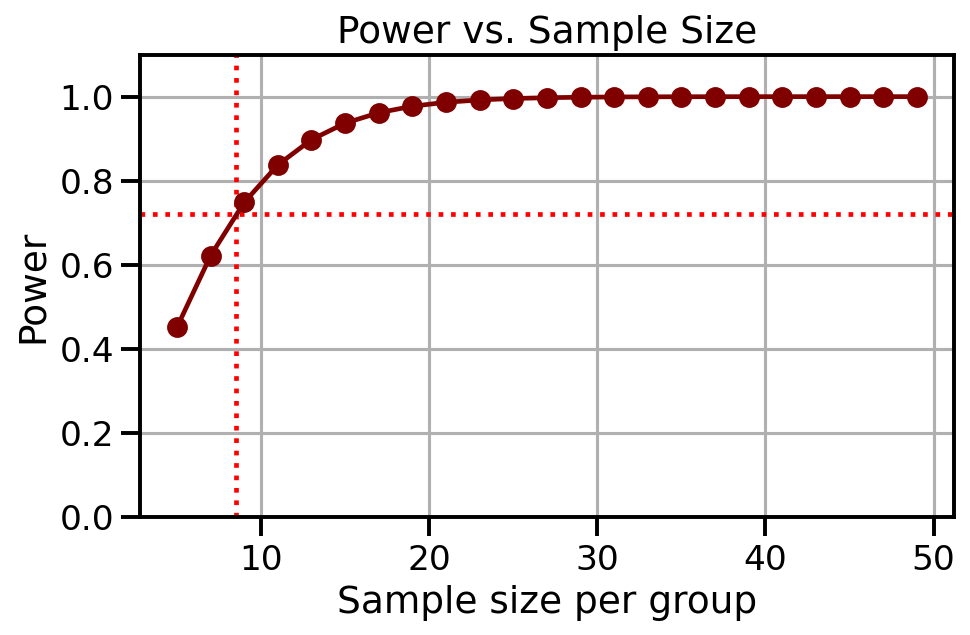

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

# Suppose from your prior analysis:
effect_size = 1.32  # Observed Cohen's d from your dataset

analysis = TTestIndPower()

# Let's vary sample size from 5 up to 50 (for group 1)
sample_sizes = range(5, 51, 2)

# Assume equal group sizes for simplicity, so ratio=1.0
# (If you want to preserve the ratio ~ 9/8 from your real data, use ratio=9/8.)
power_values = [
    analysis.power(
        effect_size=effect_size, nobs1=n, alpha=0.05, ratio=1.0, alternative="two-sided"
    )
    for n in sample_sizes
]


# Plot
plt.figure(figsize=(7, 4), dpi=150)
plt.axhline(0.72, color="r", linestyle=":")
plt.axvline(8.5, color="r", linestyle=":")
plt.plot(sample_sizes, power_values, marker="o", color="maroon")
plt.title("Power vs. Sample Size")
plt.xlabel("Sample size per group")
plt.ylabel("Power")
plt.ylim(0, 1.1)
plt.grid(True)
plt.show()

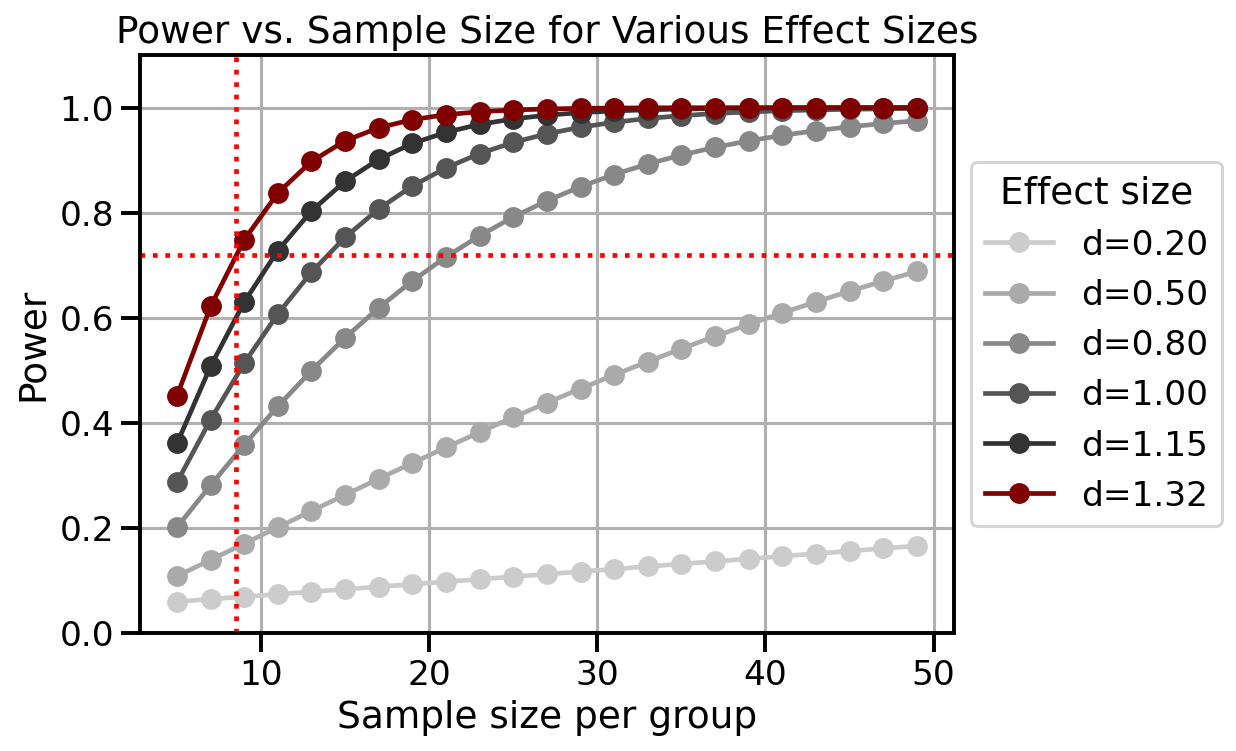

In [52]:
# List of effect sizes to plot
effect_sizes = [0.2, 0.5, 0.8, 1.0, 1.15, 1.32]

# Create an instance of TTestIndPower
analysis = TTestIndPower()

# Range of sample sizes per group
sample_sizes = range(5, 51, 2)

# Define gray shades (lightest to darkest for small->large effect sizes)
gray_colors = ["#cccccc", "#aaaaaa", "#888888", "#555555", "#333333", "maroon"]

# Plot
plt.figure(figsize=(7, 5), dpi=150)

for es, color in zip(effect_sizes, gray_colors):
    # Compute power for each sample size
    power_values = [
        analysis.power(
            effect_size=es,
            nobs1=n,
            alpha=0.05,
            ratio=1.0,  # assume equal group sizes
            alternative="two-sided",
        )
        for n in sample_sizes
    ]

    # Plot the results
    plt.plot(sample_sizes, power_values, marker="o", color=color, label=f"d={es:.2f}")
plt.axhline(0.72, color="r", linestyle=":")
plt.axvline(8.5, color="r", linestyle=":")
plt.title("Power vs. Sample Size for Various Effect Sizes")
plt.xlabel("Sample size per group")
plt.ylabel("Power")
plt.ylim(0, 1.1)
plt.grid(True)
# End of Selection
plt.legend(title="Effect size", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()